Simulate spot-level resolution data from MERFISH data (https://info.vizgen.com/mouse-brain-map)

Command line data download:
1. conda install -c conda-forge google-cloud-sdk
2. gcloud auth login --no-launch-browser
3. gsutil -m cp -r "gs://public-datasets-vizgen-merfish/datasets/mouse_brain_map/BrainReceptorShowcase/Slice1/Replicate2" .

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tifffile
import cv2
import h5py
from shapely.geometry import Point, MultiPoint
from scipy.spatial import cKDTree
import ast
import glob
import re
from pathlib import Path
from shapely.geometry import Polygon

In [2]:
fish_df = pd.read_csv('/orcd/data/omarabu/001/jiaqilu/project/count_dataset/Vizgen_MERFISH/data/BrainReceptorShowcase/Slice1/Replicate2/detected_transcripts_S1R2.csv', index_col=0)

barcode_to_gene = fish_df[['barcode_id', 'gene']]
barcode_to_gene.to_csv('saved/barcode_to_gene.csv', index=False)

matrix_filename = '/orcd/data/omarabu/001/jiaqilu/project/count_dataset/Vizgen_MERFISH/data/BrainReceptorShowcase/Slice1/Replicate2/images/micron_to_mosaic_pixel_transform.csv'
transformation_matrix = pd.read_csv(matrix_filename, header=None, sep=' ').values

merfish_spots = fish_df[['barcode_id', 'global_x', 'global_y']].copy()
merfish_spots_micron = merfish_spots.rename(columns={'global_x': 'x_um','global_y': 'y_um'})
coords_um = merfish_spots_micron[['x_um','y_um']].to_numpy()
H = np.c_[coords_um, np.ones(len(coords_um))].T
out = transformation_matrix @ H
xy_pixels = (out[:2] / out[2]).T
merfish_spots_pixel = merfish_spots_micron.copy()
merfish_spots_pixel['x_px'] = xy_pixels[:,0]
merfish_spots_pixel['y_px'] = xy_pixels[:,1]
merfish_spots_pixel.to_csv('saved/merfish_spots.csv', index=False)

In [3]:
def make_tissue_outline(df, xcol="global_x", ycol="global_y"):
    """
    Build a tissue polygon as the convex hull of all transcript coordinates.
    Returns a shapely Polygon.
    """
    pts = MultiPoint(np.vstack([df[xcol].values, df[ycol].values]).T)
    hull = pts.convex_hull  # robust & dependency-light
    return hull

def make_grid_within_polygon(poly, step_um=100.0):
    """
    Create a square grid (step = step_um) over the polygon bbox and keep points inside (covers) the polygon.
    Returns a DataFrame with columns ['spot_id','x','y'].
    """
    minx, miny, maxx, maxy = poly.bounds
    xs = np.arange(minx, maxx + step_um, step_um)
    ys = np.arange(miny, maxy + step_um, step_um)

    gx, gy = np.meshgrid(xs, ys)
    grid_points = np.vstack([gx.ravel(), gy.ravel()]).T

    keep = []
    for i, (x, y) in enumerate(grid_points):
        if poly.covers(Point(x, y)):  # includes boundary
            keep.append((i, x, y))
    spots_df = pd.DataFrame(keep, columns=["spot_id", "x", "y"]).reset_index(drop=True)
    spots_df["spot_id"] = np.arange(len(spots_df), dtype=int)
    return spots_df

def plot_outline_and_grid(poly, spots_df, spot_size=1, show_circles=False, circle_radius_um=50.0, max_circles=50):
    """
    Quick visual sanity check: tissue outline + grid spots, optionally a few spot circles.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    if poly.geom_type == "Polygon":
        x, y = poly.exterior.xy
        ax.plot(x, y)
    else:
        for geom in poly.geoms:
            x, y = geom.exterior.xy
            ax.plot(x, y)

    ax.scatter(spots_df["x"], spots_df["y"], s=spot_size)

    if show_circles and len(spots_df):
        for _, row in spots_df.sample(min(max_circles, len(spots_df)), random_state=0).iterrows():
            circle = plt.Circle((row["x"], row["y"]), circle_radius_um, fill=False, lw=0.5)
            ax.add_patch(circle)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("global_x (µm)")
    ax.set_ylabel("global_y (µm)")
    ax.set_title("Tissue outline + grid spots")
    plt.tight_layout()
    plt.show()

fish_df = pd.read_csv('/orcd/data/omarabu/001/jiaqilu/project/count_dataset/Vizgen_MERFISH/data/BrainReceptorShowcase/Slice1/Replicate2/detected_transcripts_S1R2.csv', index_col=0)
fish_df = fish_df.dropna(subset=["global_x", "global_y", "barcode_id"])
tissue_poly = make_tissue_outline(fish_df, xcol="global_x", ycol="global_y")
spots_df = make_grid_within_polygon(tissue_poly, step_um=100.0)

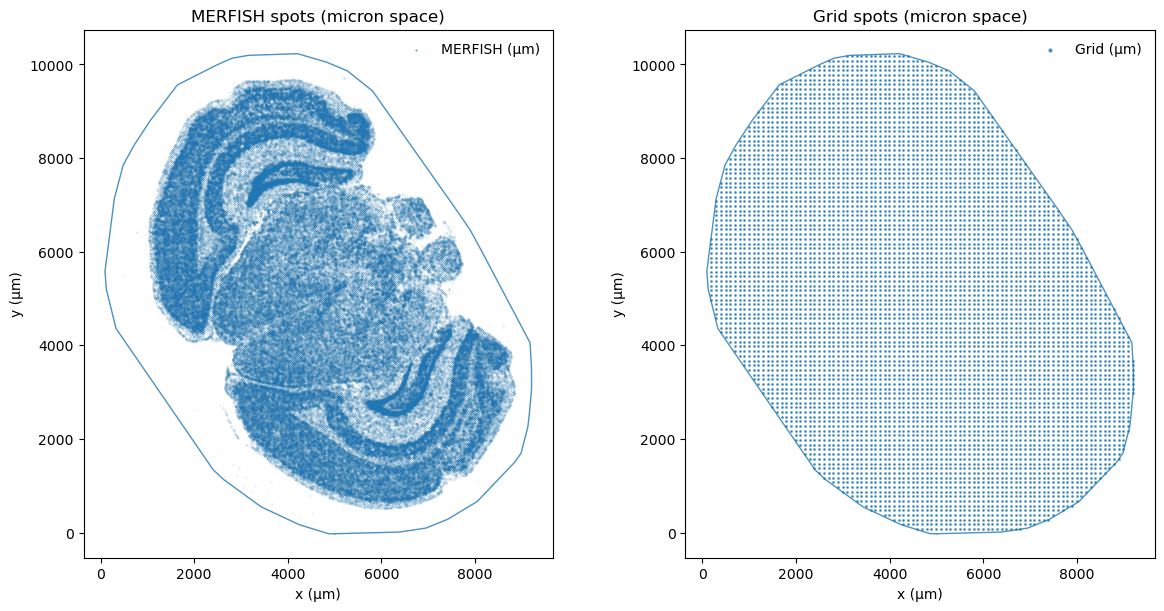

In [4]:
# --- Side-by-side: MERFISH (micron) vs Grid (micron) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Left: MERFISH spots in microns
ax = axes[0]
# outline
if tissue_poly.geom_type == "Polygon":
    xh, yh = tissue_poly.exterior.xy
    ax.plot(xh, yh, lw=1, alpha=0.8)
else:
    for g in tissue_poly.geoms:
        xh, yh = g.exterior.xy
        ax.plot(xh, yh, lw=1, alpha=0.8)

# subsample for speed if huge
N = len(merfish_spots_micron)
idx = np.arange(N)
if N > 300_000:
    idx = np.random.default_rng(0).choice(N, 300_000, replace=False)

ax.scatter(merfish_spots_micron.iloc[idx]['x_um'],
           merfish_spots_micron.iloc[idx]['y_um'],
           s=0.01, alpha=0.6, label="MERFISH (µm)")
ax.set_title("MERFISH spots (micron space)")
ax.set_xlabel("x (µm)"); ax.set_ylabel("y (µm)")
ax.set_aspect('equal', adjustable='box')
ax.legend(frameon=False, markerscale=6)

# Right: Grid in microns
ax = axes[1]
# outline
if tissue_poly.geom_type == "Polygon":
    xh, yh = tissue_poly.exterior.xy
    ax.plot(xh, yh, lw=1, alpha=0.8)
else:
    for g in tissue_poly.geoms:
        xh, yh = g.exterior.xy
        ax.plot(xh, yh, lw=1, alpha=0.8)

ax.scatter(spots_df["x"], spots_df["y"], s=1, alpha=0.7, label="Grid (µm)")
ax.set_title("Grid spots (micron space)")
ax.set_xlabel("x (µm)"); ax.set_ylabel("y (µm)")
ax.set_aspect('equal', adjustable='box')
ax.legend(frameon=False, markerscale=2)

plt.show()


In [ ]:
def _promote_transform(A):
    A = np.asarray(A, dtype=float)
    return A

def _apply_transform_xy(A, xy_um):
    """xy_um: (N,2) -> (N,2) pixels"""
    H = np.c_[xy_um, np.ones(len(xy_um))].T   # (3,N)
    out = A @ H                               # (3,N)
    xy_px = (out[:2] / out[2]).T              # (N,2)
    return xy_px

def aggregate_barcodes_to_spots(
    fish_df,
    spots_df,
    radius_um=55.0,
    xcol="global_x",
    ycol="global_y",
    barcode_col="barcode_id",
    weighting="none",
    beta=None,
    seed=None,
    A=None,                     
):
    """
    Assign each transcript to exactly ONE spot (within radius), then count per (spot, barcode).
    Returns: [spot_id, x_um, y_um, (x_px, y_px if A), barcode_id, count]
    """
    spot_coords = spots_df[["x_um", "y_um"]].to_numpy() if {"x_um","y_um"}.issubset(spots_df.columns) \
                  else spots_df[["x", "y"]].rename(columns={"x":"x_um","y":"y_um"}).to_numpy()
    spot_tree = cKDTree(spot_coords)
    tx_coords = fish_df[[xcol, ycol]].to_numpy()
    barcodes = fish_df[barcode_col].to_numpy()

    if weighting not in {"none", "exp"}:
        raise ValueError("weighting must be 'none' or 'exp'")

    # Case 1: nearest
    if weighting == "none":
        try:
            dists, idx = spot_tree.query(tx_coords, k=1, workers=-1)
        except TypeError:
            dists, idx = spot_tree.query(tx_coords, k=1)
        mask = dists <= radius_um
        if not np.any(mask):
            cols = ["spot_id", "x_um", "y_um", barcode_col, "count"]
            if A is not None: cols = ["spot_id","x_um","y_um","x_px","y_px",barcode_col,"count"]
            return pd.DataFrame(columns=cols)
        assigned_spot = idx[mask]
        assigned_barcode = barcodes[mask]

    # Case 2: exponential
    else:
        if beta is None:
            beta = np.log(2) / (radius_um / 2.0)
        rng = np.random.default_rng(seed)
        neigh_lists = spot_tree.query_ball_point(tx_coords, r=radius_um)
        assigned_spot_list, assigned_barcode_list = [], []
        for i, neigh in enumerate(neigh_lists):
            if not neigh: continue
            neigh = np.asarray(neigh, dtype=int)
            d = np.sqrt(((spot_coords[neigh] - tx_coords[i])**2).sum(axis=1))
            w = np.exp(-beta * d); p = w / w.sum()
            pick = rng.choice(neigh, p=p)
            assigned_spot_list.append(pick)
            assigned_barcode_list.append(barcodes[i])
        if len(assigned_spot_list) == 0:
            cols = ["spot_id", "x_um", "y_um", barcode_col, "count"]
            if A is not None: cols = ["spot_id","x_um","y_um","x_px","y_px",barcode_col,"count"]
            return pd.DataFrame(columns=cols)
        assigned_spot = np.asarray(assigned_spot_list, dtype=int)
        assigned_barcode = np.asarray(assigned_barcode_list)

    # counts per (spot, barcode)
    out = pd.DataFrame({"spot_id": assigned_spot, barcode_col: assigned_barcode})

    # Ensure spots_df has x_um,y_um columns for merge
    if {"x_um","y_um"}.issubset(spots_df.columns):
        spots_xy = spots_df[["spot_id","x_um","y_um"]]
    else:
        spots_xy = spots_df.rename(columns={"x":"x_um","y":"y_um"})[["spot_id","x_um","y_um"]]

    df = (
        out.value_counts(["spot_id", barcode_col])
           .rename("count").reset_index()
           .merge(spots_xy, on="spot_id", how="left")
    )

    if A is not None:
        A = _promote_transform(A)
        xy_px = _apply_transform_xy(A, df[["x_um","y_um"]].to_numpy())
        df["x_px"] = xy_px[:,0]
        df["y_px"] = xy_px[:,1]
        df = df.loc[:, ["spot_id","x_um","y_um","x_px","y_px", barcode_col,"count"]]
    else:
        df = df.loc[:, ["spot_id","x_um","y_um", barcode_col,"count"]]

    return df

matrix_filename = '/orcd/data/omarabu/001/jiaqilu/project/count_dataset/Vizgen_MERFISH/data/BrainReceptorShowcase/Slice1/Replicate2/images/micron_to_mosaic_pixel_transform.csv'
transformation_matrix = pd.read_csv(matrix_filename, header=None, sep=' ').values

# simulate_spots_hard = aggregate_barcodes_to_spots(fish_df, spots_df, radius_um=55.0, weighting="none", A=transformation_matrix)
# simulate_spot_hard.to_csv("saved/simulate_spots_deterministic.csv")

simulate_spots_prob = aggregate_barcodes_to_spots(fish_df, spots_df, radius_um=55.0, weighting="exp", beta=None, seed=0, A=transformation_matrix)

pivoted = simulate_spots_prob.pivot_table(
    index=["spot_id", "x_um", "y_um", "x_px", "y_px"],  # keep these as unique identifiers
    columns="barcode_id",
    values="count",
    fill_value=0,    # fill missing counts with zero
    aggfunc="sum"    # in case duplicates exist
).reset_index()

pivoted.columns.name = None

# order: meta cols first, then barcode cols sorted numerically
meta = ["spot_id", "x_um", "y_um", "x_px", "y_px"]
barcode_cols = sorted([c for c in pivoted.columns if c not in meta], key=int)
pivoted = pivoted[meta + barcode_cols]

pivoted.to_csv("saved/simulate_spots_prob.csv", index=False)

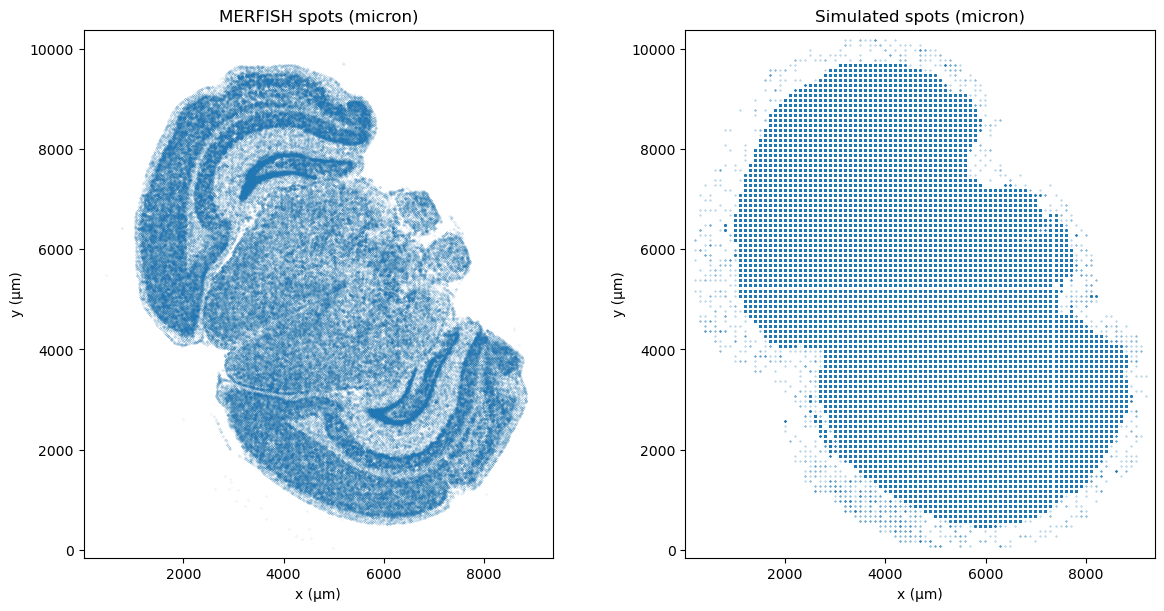

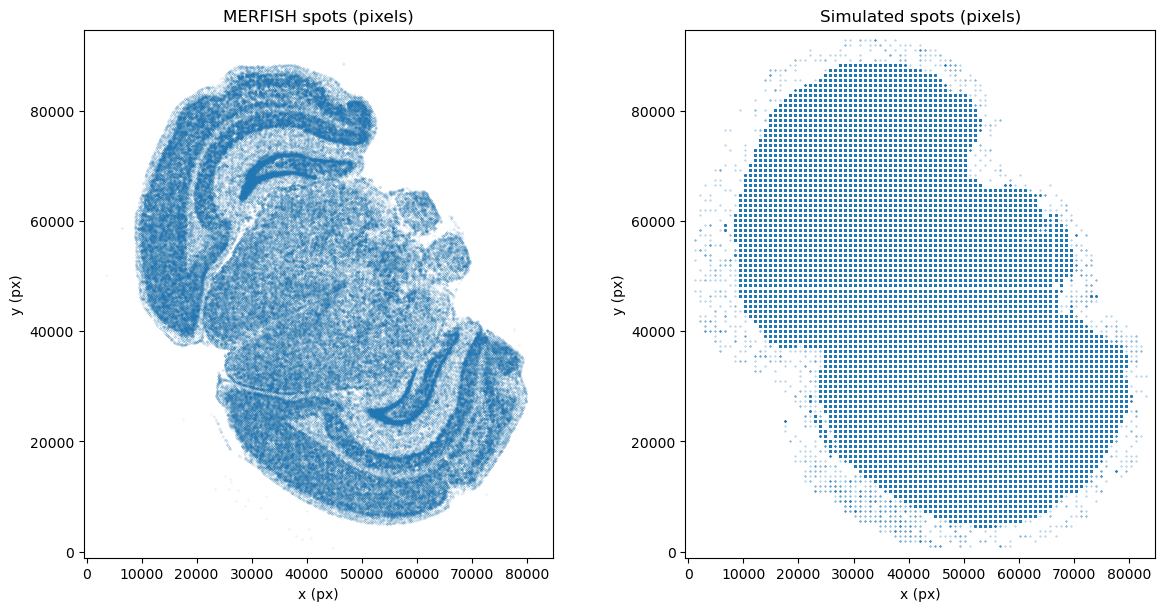

In [6]:
# 1) Load data
merfish_path = "saved/merfish_spots.csv"            
sim_path     = "saved/simulate_spots.csv"           

merfish = pd.read_csv(merfish_path)                 
sim     = pd.read_csv(sim_path)                     

# Subsample MERFISH for visualization
N = len(merfish)
idx = np.arange(N)
if N > 300_000:
    idx = np.random.default_rng(0).choice(N, 300_000, replace=False)
merfish = merfish.iloc[idx]

# Set boundary limits
def matched_limits(ax, df_a, df_b, xcol, ycol, pad=0.02):
    x_all = np.concatenate([df_a[xcol].values, df_b[xcol].values])
    y_all = np.concatenate([df_a[ycol].values, df_b[ycol].values])
    xmin, xmax = np.nanmin(x_all), np.nanmax(x_all)
    ymin, ymax = np.nanmin(y_all), np.nanmax(y_all)
    dx, dy = xmax - xmin, ymax - ymin
    ax.set_xlim(xmin - pad*dx, xmax + pad*dx)
    ax.set_ylim(ymin - pad*dy, ymax + pad*dy)

# 2) Side-by-side (µm)
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

ax = axes[0]
ax.scatter(merfish["x_um"], merfish["y_um"], s=0.01, alpha=0.6)
ax.set_title("MERFISH spots (micron)")
ax.set_xlabel("x (µm)"); ax.set_ylabel("y (µm)")
ax.set_aspect("equal", adjustable="box")

ax2 = axes[1]
ax2.scatter(sim["x_um"], sim["y_um"], s=0.1, alpha=0.6)
ax2.set_title("Simulated spots (micron)")
ax2.set_xlabel("x (µm)"); ax2.set_ylabel("y (µm)")
ax2.set_aspect("equal", adjustable="box")

# make limits comparable
matched_limits(ax,  merfish, sim, "x_um", "y_um")
matched_limits(ax2, merfish, sim, "x_um", "y_um")
plt.show()

# 3) Side-by-side (pixels)
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

ax = axes[0]
ax.scatter(merfish["x_px"], merfish["y_px"], s=0.01, alpha=0.6)
ax.set_title("MERFISH spots (pixels)")
ax.set_xlabel("x (px)"); ax.set_ylabel("y (px)")
ax.set_aspect("equal", adjustable="box")

ax2 = axes[1]
ax2.scatter(sim["x_px"], sim["y_px"], s=0.1, alpha=0.6)
ax2.set_title("Simulated spots (pixels)")
ax2.set_xlabel("x (px)"); ax2.set_ylabel("y (px)")
ax2.set_aspect("equal", adjustable="box")

matched_limits(ax,  merfish, sim, "x_px", "y_px")
matched_limits(ax2, merfish, sim, "x_px", "y_px")
plt.show()

In [13]:
# load data
base = "/orcd/data/omarabu/001/jiaqilu/project/count_dataset/Vizgen_MERFISH/data/BrainReceptorShowcase/Slice1/Replicate2"
image_path = f"{base}/images"
cellboundaries_path = f"{base}/cell_boundaries"
meta_cell = pd.read_csv(f"{base}/cell_metadata_S1R2.csv", index_col=0)

matrix_filename = f"{image_path}/micron_to_mosaic_pixel_transform.csv"
transformation_matrix = pd.read_csv(matrix_filename, header=None, sep=' ').values

# option 1: image for z slice
# z_index = 3
# image = tifffile.imread(os.path.join(image_path, f'mosaic_DAPI_z{z_index}.tif'))

# option 2: image max projection
# z_paths = sorted(glob.glob(os.path.join(image_path, "mosaic_DAPI_z*.tif")),key=lambda p: int(re.search(r'_z(\d+)\.tif$', p).group(1)))
# image = None
# for p in z_paths:
#     z_img = tifffile.imread(p)
#     if image is None:
#         image = z_img.copy()
#     else:
#         np.maximum(image, z_img, out=image)
# tifffile.imwrite("saved/mosaic_DAPI_max_projection.tif", image)
# image = tifffile.imread("saved/mosaic_DAPI_max_projection.tif")
# adjust global contrast
# low, high = np.percentile(image, (0, 99.5))
# tifffile.imwrite("saved/mosaic_DAPI_max_projection_contrast_adjusted.tif", (np.clip((image - low)/(high - low + 1e-12), 0, 1)*65535).astype(np.uint16))
image = tifffile.imread("saved/mosaic_DAPI_max_projection_contrast_adjusted.tif")

merfish_path = "saved/merfish_spots.csv"            
sim_path = "saved/simulate_spots_prob.csv"    
sim_cell_mapping_path = "saved/simulate_spots_prob_cell_mapping.csv"        
px_boundaries_path = "saved/cell_boundaries_convex_hull.csv"           
merfish = pd.read_csv(merfish_path, index_col=0)                 
sim = pd.read_csv(sim_path)  
sim_cell_mapping = pd.read_csv(sim_cell_mapping_path)
px_boundaries = pd.read_csv(px_boundaries_path)    

/home/jiaqilu/anaconda3/envs/python3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


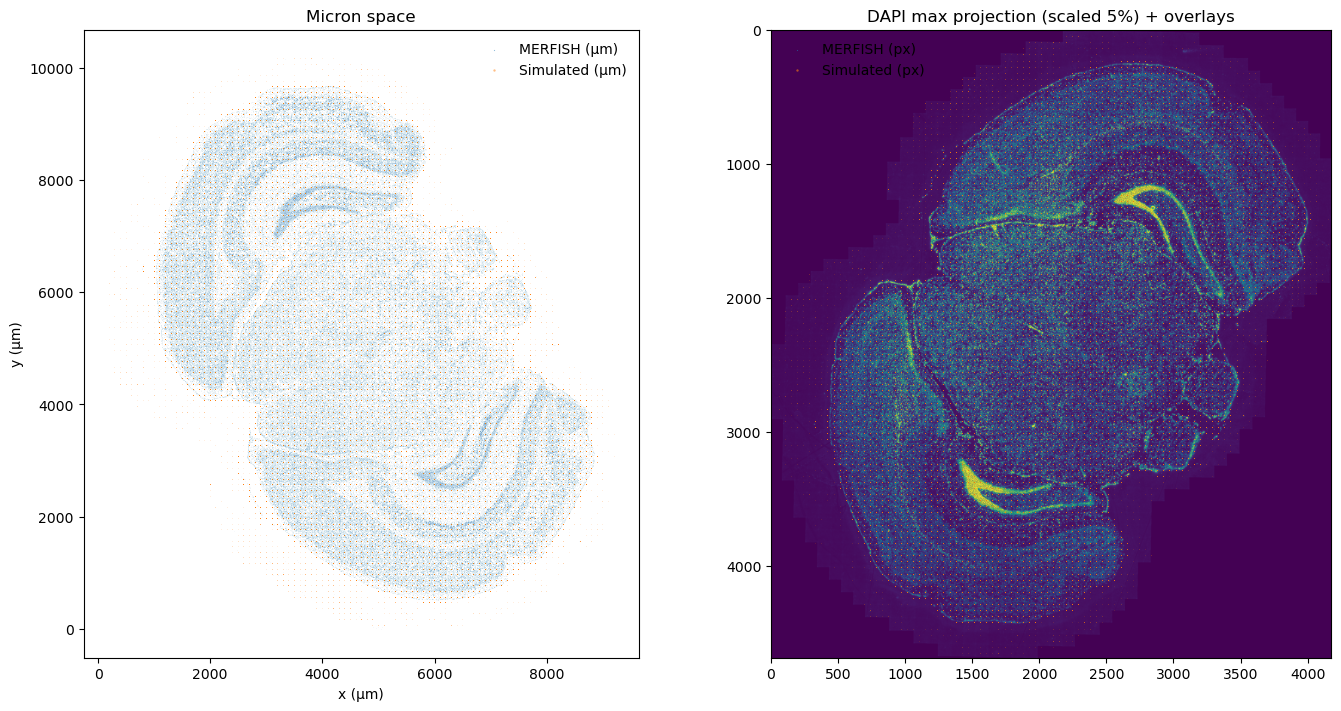

In [8]:
# ---------- Micron vs DAPI+pixels side-by-side ----------

# resize dapi for visualization
scale_percent = 5
sx = sy = scale_percent / 100.0
width  = int(image.shape[1] * sx)
height = int(image.shape[0] * sy)
resized = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

# subsample for overlay speed
N = len(merfish)
idx = np.arange(N)
if N > 500_000:
    idx = np.random.default_rng(0).choice(N, 500_000, replace=False)
merfish_subsampled = merfish.iloc[idx]

merfish_um_plot = merfish_subsampled[["x_um","y_um"]]
sim_um_plot     = sim[["x_um","y_um"]]
merfish_px_plot = merfish_subsampled[["x_px","y_px"]]
sim_px_plot     = sim[["x_px","y_px"]]

# scale pixel coords to match resized image
mx = merfish_px_plot["x_px"].values * sx
my = merfish_px_plot["y_px"].values * sy
sxp = sim_px_plot["x_px"].values * sx
syp = sim_px_plot["y_px"].values * sy
fig, axes = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

# Left: micron space (MERFISH vs Sim)
ax = axes[0]
ax.scatter(merfish_um_plot["x_um"], merfish_um_plot["y_um"], s=0.02, alpha=0.5, linewidths=0, label="MERFISH (µm)")
ax.scatter(sim_um_plot["x_um"],     sim_um_plot["y_um"],     s=0.08, alpha=0.5, linewidths=0, label="Simulated (µm)")
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("x (µm)"); ax.set_ylabel("y (µm)")
ax.set_title("Micron space")
ax.legend(frameon=False, markerscale=6)

# Right: DAPI (resized) + pixel-space overlays
ax = axes[1]
ax.imshow(resized, vmax=np.percentile(resized, 100), origin="upper")
ax.scatter(mx,  my,  s=0.02, alpha=0.6, linewidths=0, label="MERFISH (px)", color="C0")
ax.scatter(sxp, syp, s=0.08, alpha=0.6, linewidths=0, label="Simulated (px)", color="C1")
ax.set_xlim(0, width); ax.set_ylim(height, 0)  # keep image coordinates
ax.set_aspect("equal", adjustable="box")
ax.set_title(f"DAPI max projection (scaled {scale_percent}%) + overlays")
ax.legend(frameon=False, markerscale=6)
plt.show()

In [9]:
# Merge all polygons across z and take the convex hull for each cell

import os, glob, h5py
import numpy as np
import pandas as pd
from shapely.geometry import MultiPoint
import matplotlib.pyplot as plt

# functions
def load_transform(path):
    try:
        A = pd.read_csv(path, header=None, sep=r"\s+", engine="python").to_numpy(float)
    except Exception:
        A = np.loadtxt(path).astype(float)
    if A.size == 9 and A.shape != (3, 3):
        A = A.reshape(3, 3)
    if A.shape == (2, 3):
        A = np.vstack([A, [0.0, 0.0, 1.0]])
    if A.shape != (3, 3):
        raise ValueError(f"Unexpected transform shape {A.shape}")
    return A

def apply_xy(A, xy_um):
    H = np.c_[xy_um, np.ones(len(xy_um))].T  # (3,N)
    out = A @ H
    return (out[:2] / out[2]).T              # (N,2)

def choose_A_or_AT(A, xy_sample_um):
    def rt_err(B):
        px = apply_xy(B, xy_sample_um)
        Bi = np.linalg.inv(B)
        H = np.c_[px, np.ones(len(px))].T
        back = Bi @ H
        back = (back[:2]/back[2]).T
        return np.median(np.hypot(*(xy_sample_um - back).T))
    eA, eAT = rt_err(A), rt_err(A.T)
    return A if eA <= eAT else A.T

# Load transformation
A = load_transform(os.path.join(image_path, "micron_to_mosaic_pixel_transform.csv"))

try:
    mpath = os.path.join(base, "detected_transcripts_S1R2.csv")
    mdf = pd.read_csv(mpath, usecols=["global_x", "global_y"]).dropna().iloc[:10000]
    sample_um = mdf[["global_x", "global_y"]].to_numpy()
except Exception:
    sample_um = np.array([[0,0], [1000,0], [0,1000], [1000,1000]], float)

A = choose_A_or_AT(A, sample_um)

# Merge polygons across z and compute convex hull in pixel space
meta_ids = set(meta_cell.index.astype(str))
polys_px = []
cell_ids = []

for h5f in sorted(glob.glob(os.path.join(cellboundaries_path, "feature_data_*.hdf5"))):
    with h5py.File(h5f, "r") as f:
        fd = f["featuredata"]
        ids = [k for k in fd.keys() if k in meta_ids]
        if not ids:
            continue
        for cid in ids:
            all_pts_um = []
            for zname in fd[cid]:
                if not zname.startswith("zIndex_"):
                    continue
                zg = fd[cid][zname]
                for pname in zg.keys():
                    if not pname.startswith("p_"):
                        continue
                    if "coordinates" not in zg[pname]:
                        continue
                    temp_um = np.array(zg[pname]["coordinates"][:]).squeeze(0)
                    if temp_um.ndim != 2 or temp_um.shape[1] != 2:
                        continue
                    all_pts_um.extend(temp_um.tolist())
            if not all_pts_um:
                continue
            all_pts_um = np.array(all_pts_um)
            all_pts_px = apply_xy(A, all_pts_um)

            try:
                hull = MultiPoint(all_pts_px).convex_hull
                if hull.geom_type != "Polygon":
                    continue
                coords = np.array(hull.exterior.coords)  # (M, 2)
                polys_px.append(coords)
                cell_ids.append(cid)
            except Exception as e:
                print(f"Convex hull failed for cell {cid}: {e}")

# Save merged boundaries
polys_px_df = pd.DataFrame({
    "cell_id": cell_ids,
    "x_px": [arr[:, 0].tolist() for arr in polys_px],
    "y_px": [arr[:, 1].tolist() for arr in polys_px],
})

os.makedirs("saved", exist_ok=True)
polys_px_df.to_csv("saved/cell_boundaries_convex_hull.csv", index=False)
print(f"Saved merged convex hull boundaries for {len(cell_ids)} cells.")

px_boundaries_path = "saved/cell_boundaries_convex_hull.csv"           
px_boundaries = pd.read_csv(px_boundaries_path)   

# no merge of polygons per cell

# # -----------------------------
# # Transform utilities
# # -----------------------------
# def load_transform(path):
#     # Read whitespace-separated numbers robustly
#     try:
#         A = pd.read_csv(path, header=None, sep=r"\s+", engine="python").to_numpy(float)
#     except Exception:
#         A = np.loadtxt(path).astype(float)

#     # Reshape 1x9 → 3x3 if needed
#     if A.size == 9 and A.shape != (3, 3):
#         A = A.reshape(3, 3)

#     # Promote 2x3 → 3x3 homogeneous
#     if A.shape == (2, 3):
#         A = np.vstack([A, [0.0, 0.0, 1.0]])
#     if A.shape != (3, 3):
#         raise ValueError(f"Unexpected transform shape {A.shape}")
#     return A

# def apply_xy(A, xy_um):
#     H = np.c_[xy_um, np.ones(len(xy_um))].T  # (3,N)
#     out = A @ H
#     return (out[:2] / out[2]).T              # (N,2)

# def choose_A_or_AT(A, xy_sample_um):
#     # Pick the one with smaller round-trip error
#     def rt_err(B):
#         px = apply_xy(B, xy_sample_um)
#         Bi = np.linalg.inv(B)
#         H = np.c_[px, np.ones(len(px))].T
#         back = Bi @ H
#         back = (back[:2]/back[2]).T
#         return np.median(np.hypot(*(xy_sample_um - back).T))
#     eA, eAT = rt_err(A), rt_err(A.T)
#     return A if eA <= eAT else A.T

# # Load transform and pick convention
# A = load_transform(os.path.join(image_path, "micron_to_mosaic_pixel_transform.csv"))

# # If you have MERFISH (R2) coordinates around, use a quick sample to decide between A and A.T.
# # Fall back to a synthetic sample if not.
# try:
#     mpath = os.path.join(base, "detected_transcripts_S1R2.csv")
#     mdf = pd.read_csv(mpath, usecols=["global_x", "global_y"]).dropna().iloc[:10000]
#     sample_um = mdf[["global_x","global_y"]].to_numpy()
# except Exception:
#     sample_um = np.array([[0,0],[1000,0],[0,1000],[1000,1000]], float)

# A = choose_A_or_AT(A, sample_um)

# # -----------------------------
# # Collect polygons (microns → pixels)
# # -----------------------------
# meta_ids = set(meta_cell.index.astype(str))
# polys_px = []
# cell_ids = []

# for h5f in sorted(glob.glob(os.path.join(cellboundaries_path, "feature_data_*.hdf5"))):
#     with h5py.File(h5f, "r") as f:
#         fd = f["featuredata"]
#         ids = [k for k in fd.keys() if k in meta_ids]  # keep only metadata-matching IDs
#         if not ids:
#             continue
#         for cid in ids:
#             zname = f"zIndex_{z_index}"
#             if zname not in fd[cid]:
#                 continue
#             zg = fd[cid][zname]
#             for pname in zg.keys():                     # p_0, p_1, ...
#                 if not pname.startswith("p_"): 
#                     continue
#                 if "coordinates" not in zg[pname]:
#                     continue
#                 temp_um = np.array(zg[pname]["coordinates"][:]).squeeze(0)  # (N,2) microns
#                 if temp_um.ndim != 2 or temp_um.shape[1] != 2:
#                     continue
#                 xy_px = apply_xy(A, temp_um)                                 # (N,2) pixels
#                 polys_px.append(xy_px)
#                 cell_ids.append(cid)

# polys_px_df = pd.DataFrame({
#     "cell_id": cell_ids,
#     "x_px": [arr[:, 0].tolist() for arr in polys_px],
#     "y_px": [arr[:, 1].tolist() for arr in polys_px],
# })

# polys_px_df.to_csv("saved/cell_boundaries.csv", index=False)

Saved merged convex hull boundaries for 88884 cells.


In [15]:
# visualize h5 file structure

# def print_h5_structure(h5file):
#     def visitor(name, node):
#         indent = "  " * name.count('/')
#         if isinstance(node, h5py.Group):
#             print(f"{indent}{name}/")
#         elif isinstance(node, h5py.Dataset):
#             shape = node.shape
#             dtype = node.dtype
#             print(f"{indent}{name}  [Dataset, shape={shape}, dtype={dtype}]")
#     h5file.visititems(visitor)

# # Path to boundaries
# boundary_files = sorted(glob.glob(os.path.join(cellboundaries_path, "feature_data_*.hdf5")))

# # Preview structure of the first one
# if boundary_files:
#     print(f"Inspecting: {boundary_files[0]}")
#     with h5py.File(boundary_files[0], "r") as f:
#         print_h5_structure(f)
# else:
#     print("No feature_data_*.hdf5 files found.")


Cropped image shape: (1927, 1963)


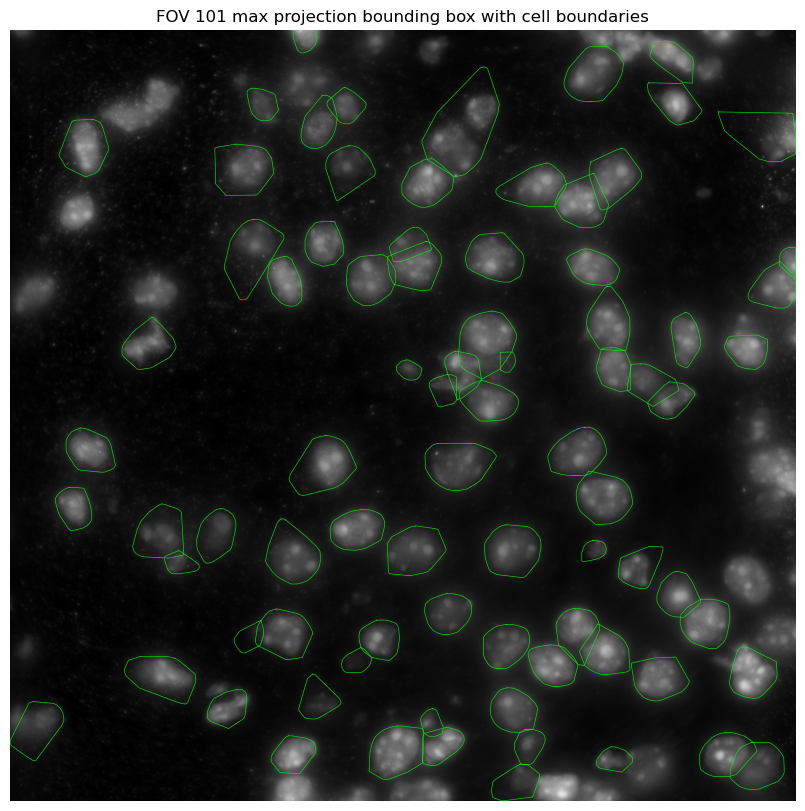

In [10]:
# visualize a random fov for sanity check
fov_to_show = 101
cells_in_fov = meta_cell[meta_cell.fov == fov_to_show].index.astype(str)
boundaries_in_fov = px_boundaries[px_boundaries["cell_id"].astype(str).isin(cells_in_fov)]

selected_polys = []
for _, row in boundaries_in_fov.iterrows():
    try:
        x = np.array(ast.literal_eval(row["x_px"]), dtype=float)
        y = np.array(ast.literal_eval(row["y_px"]), dtype=float)
        if len(x) != len(y):
            continue
        poly = np.stack([x, y], axis=1)
        selected_polys.append(poly)
    except Exception as e:
        print(f"Error parsing boundary for cell_id {row['cell_id']}: {e}")

xmins, xmaxs, ymins, ymaxs = [], [], [], []

for poly in selected_polys:
    xmins.append(poly[:, 0].min())
    xmaxs.append(poly[:, 0].max())
    ymins.append(poly[:, 1].min())
    ymaxs.append(poly[:, 1].max())

xmin_global = int(np.floor(min(xmins)))
xmax_global = int(np.ceil(max(xmaxs)))
ymin_global = int(np.floor(min(ymins)))
ymax_global = int(np.ceil(max(ymaxs)))

bbox_crop = image[ymin_global:ymax_global, xmin_global:xmax_global]
print(f"Cropped image shape: {bbox_crop.shape}")

Y_FLIP = False

img = bbox_crop.copy()
H, W = img.shape

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
ax.imshow(img, cmap='gray', vmax=np.percentile(img, 100), origin="upper")

for poly in selected_polys:
    x = poly[:, 0] - xmin_global  # shift x to local bbox coords
    y = poly[:, 1] - ymin_global  # shift y to local bbox coords
    if Y_FLIP:
        y = img.shape[0] - 1 - y
    ax.plot(x, y, lw=0.5, alpha=0.8, color="lime")

ax.set_xlim(0, W)
ax.set_ylim(H, 0)
ax.set_aspect("equal")
ax.set_title(f"FOV {fov_to_show} max projection bounding box with cell boundaries")
ax.axis("off")
plt.show()

In [11]:
fov_list = sorted({
    int(m.group(1))
    for p in Path(cellboundaries_path).glob("feature_data_*.hdf5")
    for m in [re.search(r"feature_data_(\d+)\.hdf5$", p.name)]
    if m})

boundaries_in_fov_list = []
for i in fov_list:
    cells_in_fov = meta_cell.loc[meta_cell["fov"] == i].index.astype(str)
    df_i = px_boundaries[px_boundaries["cell_id"].astype(str).isin(cells_in_fov)].copy()
    df_i["fov"] = i
    boundaries_in_fov_list.append(df_i)
boundaries_in_fov_list = pd.concat(boundaries_in_fov_list, ignore_index=True)

In [12]:
# crop single cells
outdir = "saved/single_cells"
os.makedirs(outdir, exist_ok=True)

saved_count, skipped = 0, []

for _, row in boundaries_in_fov_list.iterrows():
    cell_id = str(row["cell_id"])
    try:
        # parse polygon
        x = np.array(ast.literal_eval(row["x_px"]), dtype=float)
        y = np.array(ast.literal_eval(row["y_px"]), dtype=float)
        if x.size == 0 or y.size == 0 or len(x) != len(y):
            continue

        xmin = int(np.floor(np.min(x)))
        xmax = int(np.ceil (np.max(x))) + 1  # +1 so the max index is included
        ymin = int(np.floor(np.min(y)))
        ymax = int(np.ceil (np.max(y))) + 1

        H, W = image.shape
        xmin = max(0, min(W, xmin))
        xmax = max(0, min(W, xmax))
        ymin = max(0, min(H, ymin))
        ymax = max(0, min(H, ymax))

        if xmax <= xmin or ymax <= ymin:
            skipped.append((cell_id, "degenerate bbox"))
            continue

        crop = image[ymin:ymax, xmin:xmax]
        if crop.size == 0:
            skipped.append((cell_id, "empty crop"))
            continue

        outpath = os.path.join(outdir, f"{cell_id}.tiff")
        tifffile.imwrite(outpath, crop)
        saved_count += 1

    except Exception as e:
        skipped.append((cell_id, f"error: {e}"))

print(f"Saved {saved_count} single-cell crops to {outdir}")

Saved 88884 single-cell crops to saved/single_cells


In [ ]:
# load simulated spots coordinates and cell boundaries
# here i want to document the cell id that has contributed to each spot
# the way i do it is to check if the cell centroid falls within the spot radius
# compute cell centroids from pixel boundaries, then transform to micron space
# for each spot, find all cell centroids within 55 um, record the spot id and cell id

def _promote_transform(A):
    return np.asarray(A, dtype=float)

def _apply_transform_xy(A, xy_um):
    H = np.c_[xy_um, np.ones(len(xy_um))].T   # (3,N)
    out = A @ H
    return (out[:2] / out[2]).T  # (N,2)

def _apply_inverse_transform_xy(A, xy_px):
    """Apply inverse transform from pixel → micron space"""
    A_inv = np.linalg.inv(_promote_transform(A))
    return _apply_transform_xy(A_inv, xy_px)

# --- Load data ---
sim = pd.read_csv("saved/simulate_spots_prob.csv")
px_boundaries = pd.read_csv("saved/cell_boundaries_convex_hull.csv")
A = pd.read_csv(
    "/orcd/data/omarabu/001/jiaqilu/project/count_dataset/Vizgen_MERFISH/data/BrainReceptorShowcase/Slice1/Replicate2/images/micron_to_mosaic_pixel_transform.csv",
    header=None, sep=" "
).values

# --- Compute cell centroids ---
centroids_px = []
cell_ids = []
for _, row in px_boundaries.iterrows():
    try:
        x = eval(row["x_px"])
        y = eval(row["y_px"])
    except:
        continue
    if len(x) < 3:
        continue  # skip degenerate polygons
    poly = Polygon(zip(x, y))
    centroid = poly.centroid
    centroids_px.append((centroid.x, centroid.y))
    cell_ids.append(row["cell_id"])

centroids_px = np.array(centroids_px)
cell_ids = np.array(cell_ids)

# --- Transform to micron ---
centroids_um = _apply_inverse_transform_xy(A, centroids_px)

# --- Save centroids with cell_id ---
centroid_df = pd.DataFrame({
    "cell_id": cell_ids,
    "x_px": centroids_px[:, 0],
    "y_px": centroids_px[:, 1],
    "x_um": centroids_um[:, 0],
    "y_um": centroids_um[:, 1],
})
centroid_df.to_csv("saved/cell_centroids.csv", index=False)

# --- Build KDTree for cell centroids ---
cell_centroid_tree = cKDTree(centroids_um)

# --- For each spot, find all nearby cell centroids within radius ---
radius_um = 55.0
sim_unique = sim.drop_duplicates("spot_id")[["spot_id", "x_um", "y_um"]]
spot_coords_um = sim_unique[["x_um", "y_um"]].to_numpy()
spot_to_cells = cell_centroid_tree.query_ball_point(spot_coords_um, r=radius_um)

# --- Build long-form [spot_id, cell_id] pairs ---
spot_to_cell_ids = []
for spot_idx, cell_idxs in enumerate(spot_to_cells):
    spot_id = int(sim_unique.iloc[spot_idx]["spot_id"])
    cell_id_list = [cell_ids[cell_idx] for cell_idx in cell_idxs]
    spot_to_cell_ids.append({"spot_id": spot_id, "cell_ids": cell_id_list})


# --- Save result ---
df = pd.DataFrame(spot_to_cell_ids)
df["cell_ids"] = df["cell_ids"].apply(lambda ids: ",".join(map(str, ids)))
df.to_csv("saved/spot_to_cell_ids.csv", index=False)

# merge spot_to_cell mapping back into simulate_spots_prob
simulate_spots_prob = pd.read_csv("saved/simulate_spots_prob.csv", index_col=False)
simulate_spots_prob_cell_mapping = simulate_spots_prob.merge(
    df[["spot_id", "cell_ids"]],
    on="spot_id",
    how="left"
)
simulate_spots_prob_cell_mapping.to_csv("saved/simulate_spots_prob_cell_mapping.csv",index=False)

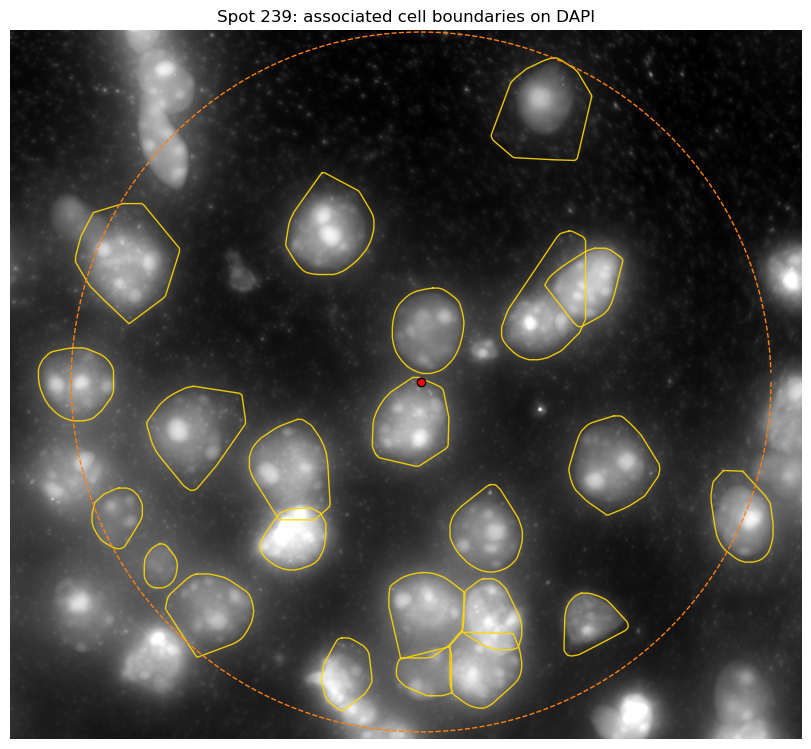

In [14]:
# ---------- pick the spot ----------
spot_id_to_show = 239
rows = sim_cell_mapping.loc[sim_cell_mapping["spot_id"] == spot_id_to_show].copy()

if rows.empty:
    raise ValueError(f"No rows found for spot_id={spot_id_to_show}")

# unify cell_ids across barcode rows for this spot
cell_id_lists = (
    rows["cell_ids"]
    .dropna()
    .astype(str)
    .str.split(",")
    .tolist()
)
cell_ids_for_spot = set(cid.strip() for lst in cell_id_lists for cid in lst if cid.strip() != "")

# get spot coordinates (use the first row; they should be identical for a spot)
spot_x_px = float(rows.iloc[0]["x_px"])
spot_y_px = float(rows.iloc[0]["y_px"])
spot_x_um = float(rows.iloc[0]["x_um"])
spot_y_um = float(rows.iloc[0]["y_um"])

# ---------- gather boundaries for those cell_ids ----------
boundaries_for_spot = px_boundaries[px_boundaries["cell_id"].astype(str).isin(cell_ids_for_spot)]

selected_polys = []
for _, row in boundaries_for_spot.iterrows():
    try:
        x = np.array(ast.literal_eval(row["x_px"]), dtype=float)
        y = np.array(ast.literal_eval(row["y_px"]), dtype=float)
        if len(x) != len(y) or len(x) < 3:
            continue
        selected_polys.append(np.stack([x, y], axis=1))
    except Exception:
        continue

if not selected_polys:
    print(f"No boundaries found for spot_id={spot_id_to_show} (cell_ids={list(cell_ids_for_spot)[:10]}...)")

# ---------- choose a tight crop that includes all selected cells + the spot ----------
pad = 40  # pixels
xs = [spot_x_px]
ys = [spot_y_px]
for poly in selected_polys:
    xs.extend([poly[:, 0].min(), poly[:, 0].max()])
    ys.extend([poly[:, 1].min(), poly[:, 1].max()])

xmin_global = max(0, int(np.floor(min(xs) - pad)))
xmax_global = min(image.shape[1], int(np.ceil(max(xs) + pad)))
ymin_global = max(0, int(np.floor(min(ys) - pad)))
ymax_global = min(image.shape[0], int(np.ceil(max(ys) + pad)))

bbox_crop = image[ymin_global:ymax_global, xmin_global:xmax_global]
H, W = bbox_crop.shape

# ---------- (optional) draw the 55 µm "radius" ring via homography (ellipse after transform) ----------
radius_um = 55.0
thetas = np.linspace(0, 2*np.pi, 240, endpoint=False)
ring_um = np.stack([
    spot_x_um + radius_um * np.cos(thetas),
    spot_y_um + radius_um * np.sin(thetas)
], axis=1)
ring_px = _apply_transform_xy(A, ring_um)  # maps micron->pixel

# shift to local bbox
ring_px_local = np.stack([ring_px[:, 0] - xmin_global, ring_px[:, 1] - ymin_global], axis=1)

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
ax.imshow(bbox_crop, cmap="gray", vmax=np.percentile(bbox_crop, 99.8), origin="upper")

# cell boundaries associated with the spot
for poly in selected_polys:
    x = poly[:, 0] - xmin_global
    y = poly[:, 1] - ymin_global
    ax.plot(x, y, lw=1.0, alpha=0.9, color="gold")

# spot center (pixel) shifted to local bbox
ax.plot(spot_x_px - xmin_global, spot_y_px - ymin_global, marker="o", ms=6, mec="black", mfc="red", lw=0)

# 55 µm ring (projected ellipse)
ax.plot(ring_px_local[:, 0], ring_px_local[:, 1], lw=1.0, ls="--")

ax.set_xlim(0, W)
ax.set_ylim(H, 0)
ax.set_aspect("equal")
ax.set_title(f"Spot {spot_id_to_show}: associated cell boundaries on DAPI")
ax.axis("off")
plt.show()
